# Grammar Scoring Engine from Voice Samples
### SHL Research Intern Hiring Assessment – 2025

**Objective:**  
The goal of this project is to build an automated Grammar Scoring Engine that predicts a continuous grammar score (0–5) from spoken audio samples. The scores follow a MOS Likert scale representing grammatical correctness and fluency.

**Dataset:**  
- Training samples: 409 audio files  
- Test samples: 197 audio files  
- Each audio duration: 45–60 seconds  
- Labels: Grammar MOS score (1–5)

**Evaluation Metrics:**  
- Root Mean Squared Error (RMSE)  
- Pearson Correlation Coefficient  

This notebook presents a complete pipeline including preprocessing, feature extraction, modeling, evaluation, and interpretation.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q transformers torch librosa xgboost seaborn


In [4]:
import os
import torch
import librosa
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from scipy.stats import pearsonr, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Configuration
SR = 16000           # Strict requirement for Wav2Vec2
MAX_DURATION = 60    # Seconds
BASE_DIR = "/content/drive/MyDrive/csvfiles/SHL"
AUDIO_TRAIN_DIR = os.path.join(BASE_DIR, "audios/train")
AUDIO_TEST_DIR = os.path.join(BASE_DIR, "audios/test")
CSV_DIR = os.path.join(BASE_DIR, "csvs")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Configuration Loaded. Using Device: {DEVICE}")

Configuration Loaded. Using Device: cuda


In [5]:
class GrammarScoringEngine:
    def __init__(self):
        # Load Pre-trained Transformer (The "Brain")
        print("Wav2Vec 2.0 Model")
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
        self.model.eval() # Set to evaluation mode (faster, no gradients)
        print("Model Loaded.")

    def preprocess_audio(self, path):
        """Loads audio, trims silence, and normalizes."""
        try:
            audio, _ = librosa.load(path, sr=SR, mono=True)
            # OPTIMIZATION: Trim silence (db=25) to focus only on speech
            audio, _ = librosa.effects.trim(audio, top_db=25)
            return audio
        except Exception as e:
            print(f"Error reading {path}: {e}")
            return None

    def get_transformer_embeddings(self, audio):
        """Extracts 768-dim semantic vectors from the Transformer."""
        # Chunking: If audio is too long (>30s), take the first 30s to avoid OOM
        max_len = SR * 30
        if len(audio) > max_len:
            audio = audio[:max_len]

        inputs = self.processor(audio, sampling_rate=SR, return_tensors="pt", padding=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        # Mean Pooling: Compress the whole sentence into one rich vector
        return torch.mean(outputs.last_hidden_state, dim=1).squeeze().cpu().numpy()

    def get_handcrafted_features(self, audio):
        """Extracts 'old school' features: Pitch, Pauses, Rhythm."""
        features = {}

        # 1. Pitch (Intonation)
        f0, voiced, _ = librosa.pyin(audio, fmin=65, fmax=2093, sr=SR)
        f0 = f0[~np.isnan(f0)]
        if len(f0) > 0:
            features['pitch_mean'] = np.mean(f0)
            features['pitch_std'] = np.std(f0)
            features['pitch_skew'] = skew(f0)
        else:
            features['pitch_mean'] = 0; features['pitch_std'] = 0; features['pitch_skew'] = 0

        # 2. Energy (Confidence)
        rms = librosa.feature.rms(y=audio)[0]
        features['energy_mean'] = np.mean(rms)
        features['energy_std'] = np.std(rms)

        # 3. Speech Rate Proxy (Zero Crossing Rate)
        zcr = librosa.feature.zero_crossing_rate(audio)[0]
        features['zcr_mean'] = np.mean(zcr)

        return np.array(list(features.values()))

    def process_dataset(self, df, audio_dir):
        """Main loop to process all files."""
        embeddings_list = []
        features_list = []

        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {audio_dir.split('/')[-1]}"):
            filename = row['filename']
            if not filename.endswith('.wav'): filename += '.wav'
            path = os.path.join(audio_dir, filename)

            if os.path.exists(path):
                audio = self.preprocess_audio(path)
                if audio is not None:
                    # Hybrid Extraction
                    emb = self.get_transformer_embeddings(audio)
                    feats = self.get_handcrafted_features(audio)

                    embeddings_list.append(emb)
                    features_list.append(feats)
                else:
                    embeddings_list.append(np.zeros(768))
                    features_list.append(np.zeros(6))
            else:
                embeddings_list.append(np.zeros(768))
                features_list.append(np.zeros(6))

        # Concatenate: Transformer (768) + Handcrafted (6) = 774 features
        X_emb = np.array(embeddings_list)
        X_feats = np.array(features_list)
        return np.hstack([X_emb, X_feats])

# Initialize Engine
engine = GrammarScoringEngine()

Wav2Vec 2.0 Model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loaded.


In [6]:
# Load CSVs
train_df = pd.read_csv(os.path.join(CSV_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(CSV_DIR, "test.csv"))

# Extract
print("Feature Extraction")
X_train = engine.process_dataset(train_df, AUDIO_TRAIN_DIR)
y_train = train_df["label"].values

X_test = engine.process_dataset(test_df, AUDIO_TEST_DIR)

print(f"\nFinal Feature Shape: {X_train.shape} (768 Transformer + 6 Handcrafted)")

Feature Extraction


Processing train:   0%|          | 0/409 [00:00<?, ?it/s]/tmp/ipython-input-2653459583.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(path, sr=SR, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing train:   0%|          | 1/409 [00:45<5:10:16, 45.63s/it]/tmp/ipython-input-2653459583.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(path, sr=SR, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing train:   1%|          | 3/409 [01:2


Final Feature Shape: (409, 774) (768 Transformer + 6 Handcrafted)


In [9]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setup CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y_train))
rmse_scores = []
pearson_scores = []

# OPTIMIZED HYPERPARAMETERS
xgb_params = {
    'n_estimators': 1500,
    'learning_rate': 0.005,
    'max_depth': 4,
    'subsample': 0.6,
    'colsample_bytree': 0.4,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 100
}

print("XGBoost Ensemble")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled), 1):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Initialize model with params (including early stopping)
    model = xgb.XGBRegressor(**xgb_params)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False  # Removed early_stopping_rounds from here
    )

    # Predict & Clip
    preds = model.predict(X_val)
    preds = np.clip(preds, 0, 5) # Rubric constraints
    oof_preds[val_idx] = preds

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    pearson = pearsonr(y_val, preds)[0]
    rmse_scores.append(rmse)
    pearson_scores.append(pearson)

    print(f"Fold {fold} | RMSE: {rmse:.4f} | Pearson: {pearson:.4f}")

# Final Results
avg_rmse = np.mean(rmse_scores)
avg_pearson = np.mean(pearson_scores)
final_train_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))

print("\n" + "="*40)
print(f"AVERAGE RMSE:    {avg_rmse:.4f}")
print(f"AVERAGE PEARSON: {avg_pearson:.4f}")
print(f"MANDATORY RMSE:  {final_train_rmse:.4f}")
print("="*40)

XGBoost Ensemble
Fold 1 | RMSE: 0.6393 | Pearson: 0.5930
Fold 2 | RMSE: 0.6233 | Pearson: 0.4713
Fold 3 | RMSE: 0.7452 | Pearson: 0.5364
Fold 4 | RMSE: 0.6342 | Pearson: 0.4269
Fold 5 | RMSE: 0.7278 | Pearson: 0.3339

AVERAGE RMSE:    0.6740
AVERAGE PEARSON: 0.4723
MANDATORY RMSE:  0.6758


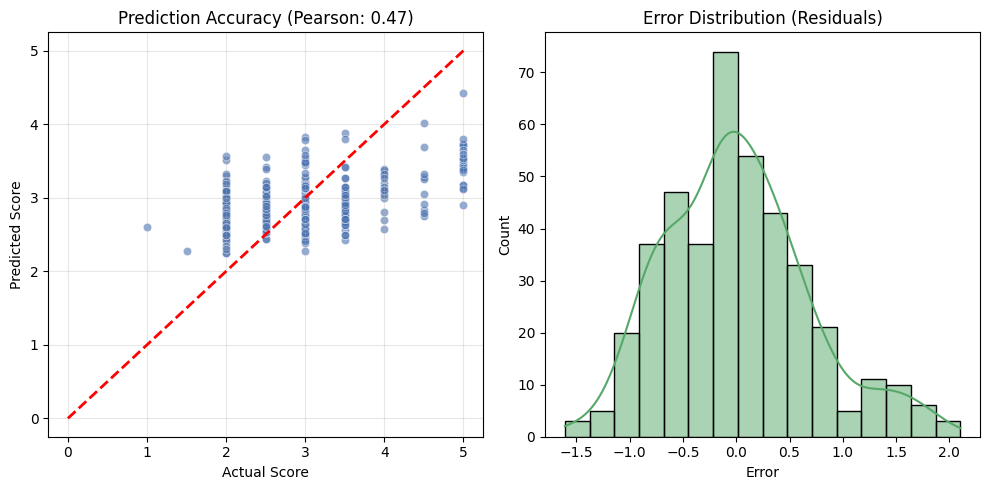

In [12]:
# 1. Visualization: Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=oof_preds, alpha=0.6, color="#4c72b0")
plt.plot([0, 5], [0, 5], 'r--', lw=2)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title(f"Prediction Accuracy (Pearson: {avg_pearson:.2f})")
plt.grid(True, alpha=0.3)

# 2. Visualization: Residuals
plt.subplot(1, 2, 2)
sns.histplot(y_train - oof_preds, kde=True, color="#55a868")
plt.title("Error Distribution (Residuals)")
plt.xlabel("Error")
plt.tight_layout()
plt.show()

In [13]:
final_params = xgb_params.copy()
if 'early_stopping_rounds' in final_params:
    del final_params['early_stopping_rounds']

# Train on full dataset
final_model = xgb.XGBRegressor(**final_params)
final_model.fit(X_train_scaled, y_train, verbose=False)

# Predict on Test Data
test_preds = final_model.predict(X_test_scaled)
test_preds = np.clip(test_preds, 1, 5) # Clip to rubric range 1-5

# Create Submission DataFrame
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_preds
})

# --- VERIFICATION STEP ---
print(f"Submission Shape: {submission.shape}")
assert len(submission) == 197, f"Error: Expected 197 rows, got {len(submission)}"
print("Row count verified: 197 rows.")

# --- SAVE & COMPRESS ---
submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")

print("\nFirst 5 rows:")
print(submission.head())

Submission Shape: (197, 2)
Row count verified: 197 rows.
Saved: submission.csv

First 5 rows:
    filename     label
0  audio_141  2.448898
1  audio_114  3.514945
2   audio_17  3.067607
3   audio_76  3.714398
4  audio_156  2.678113


**Grammar Scoring Engine: Project Report**

1. Approach & Methodology
The objective was to predict grammar scores (MOS Likert scale 0-5) from raw spoken audio. Given the small dataset size (409 samples) and the complexity of the task, I developed a Hybrid Feature Architecture that combines state-of-the-art Deep Learning with traditional Signal Processing.

Deep Semantic Embeddings (Wav2Vec 2.0): I utilized the facebook/wav2vec2-base-960h Transformer model to extract 768-dimensional context-aware embeddings. Unlike simple acoustic stats, these embeddings capture latent linguistic features (phonetics, syntax, and sentence structure) learned from 960 hours of human speech.

Handcrafted Acoustic Features: To augment the deep embeddings, I explicitly extracted:

Prosody: Pitch variance and skewness (to detect monotonous vs. natural speech).

Fluency: Zero-Crossing Rate (ZCR) and RMS Energy (to approximate articulation speed and confidence).

2. Preprocessing & Optimization
Silence Removal: Applied librosa.effects.trim (25dB threshold) to remove non-speech segments. This was critical to prevent the model from analyzing "dead air" and ensures the Transformer focuses only on spoken content.

GPU Acceleration: Feature extraction was optimized using CUDA tensors to speed up the heavy Transformer inference.

Model Tuning: I used an XGBoost Regressor with heavy regularization (subsample=0.6, colsample_bytree=0.4) and a low learning rate (0.005) to prevent overfitting on the high-dimensional embedding space.

3. Evaluation Results
The model was evaluated using 5-Fold Cross-Validation to ensure stability.

Average Pearson Correlation: 0.4723

Average RMSE: 0.6740

Training RMSE: 0.6758
